# Análise geográfica

Este notebook terá foco na análise por cidade/região.

---
### Análise inicial dos dados

In [1]:
# carregando a base
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

df = pd.read_csv('/home/l-tiezerin/mentoria_dados/data_tables/starting_df.csv')
df.head()

,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,Tenure in Months,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,9,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,IS NULL,IS NULL
1,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,9,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,IS NULL,IS NULL
2,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,4,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,13,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


In [2]:
# verificando a quantidade de cidades diferentes constando na base
df['City'].nunique()

1106

São muitas cidades diferentes para se analisar (1.106). Há concentração de clientes em alguma?

In [3]:
# verificando a proporção de clientes por cidade
df['City'].value_counts(normalize=True)*100

City
Los Angeles         4.160159
San Diego           4.046571
San Jose            1.590231
Sacramento          1.533437
San Francisco       1.476643
                      ...   
Eldridge            0.028397
Holtville           0.028397
Johannesburg        0.028397
South Lake Tahoe    0.028397
Jacumba             0.028397
Name: proportion, Length: 1106, dtype: float64

De cara é possível notar uma dispersão muito grande. A partir da terceira cidade em diante, a concentração fica em torno de 1%. As coordenadas podem ajudar a evidenciar possíveis concentrações em regiões específicas?

---
### Separação por áreas

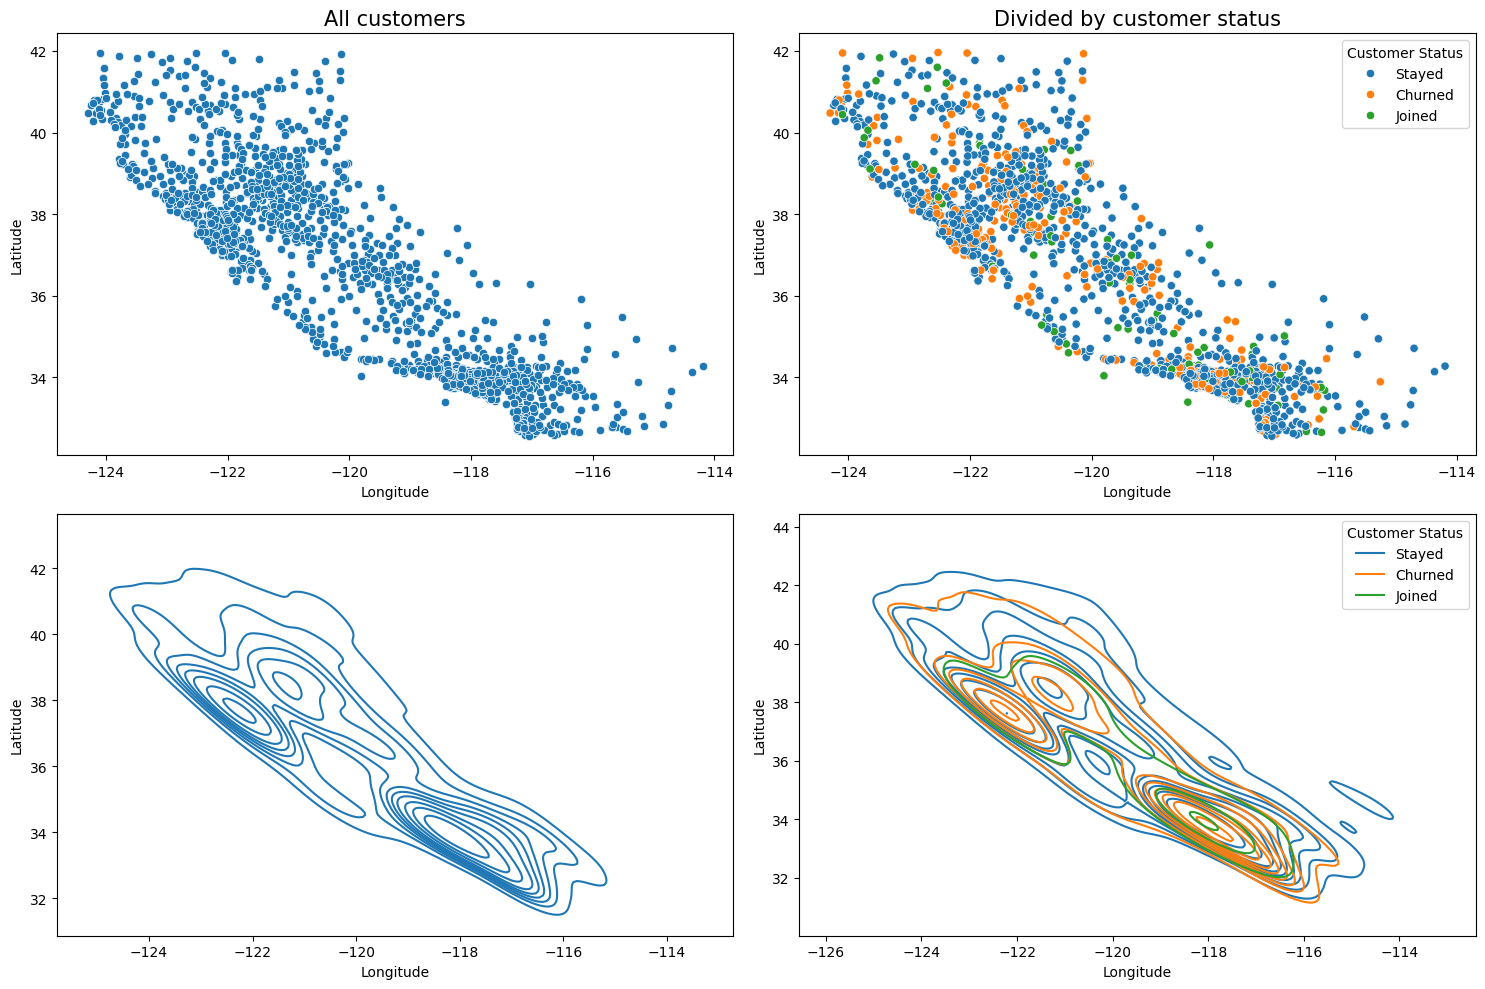

In [4]:
# visualizando clientes e status geograficamente
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 10), tight_layout=True)
axs = axs.flatten()

axs[0].set_title('All customers', size=15)
axs[1].set_title('Divided by customer status', size=15)

sns.scatterplot(data=df, x='Longitude', y='Latitude', ax=axs[0])
sns.scatterplot(data=df, x='Longitude', y='Latitude', hue='Customer Status', ax=axs[1])

sns.kdeplot(data=df, x='Longitude', y='Latitude', ax=axs[2])
sns.kdeplot(data=df, x='Longitude', y='Latitude', hue='Customer Status', ax=axs[3])

plt.show()

O mapa possui três focos, dois ao norte e um ao sul. As classificações dos clientes parecem estar bem distribuídas nas três áreas, não aparentando maior concentração em uma ou outra. Vou dividir essas áreas da seguinte forma:

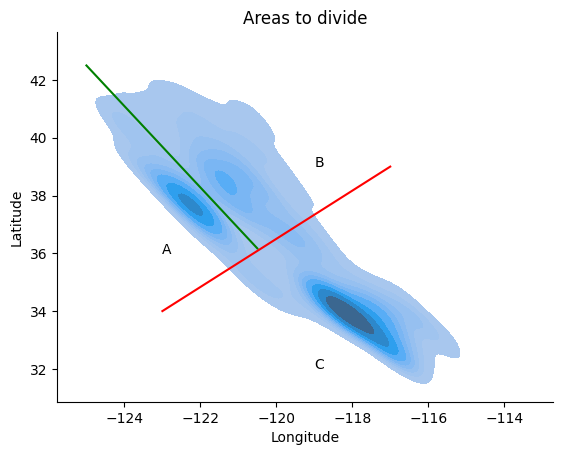

In [8]:
x1= [-125, -120.5]
y1 = [42.5, 36.17]

x2= [-123, -117]
y2 = [34, 39]

def remove_spines(axs):
    for spine in ['top', 'right']:
        axs.spines[spine].set_visible(False)

fig, axs = plt.subplots()

sns.kdeplot(data=df, x='Longitude', y='Latitude', fill=True, linewidth=0, ax=axs)
sns.lineplot(x=x1, y=y1, c='green', ax=axs)
sns.lineplot(x=x2, y=y2, c='red', ax=axs)
axs.annotate('A', [-123, 36])
axs.annotate('B', [-119, 39])
axs.annotate('C', [-119, 32])
axs.set_title('Areas to divide')
remove_spines(axs=axs)
plt.show()

Essa seria a separação que imaginei, dividindo em três áreas de acordo com a densidade dos pontos.

Tentei usar o KMeans e o DBscan, porém não ficou do jeito que eu queria. Portanto, vou definir as áreas de acordo com as posições dos clientes referentes às retas desenhadas.

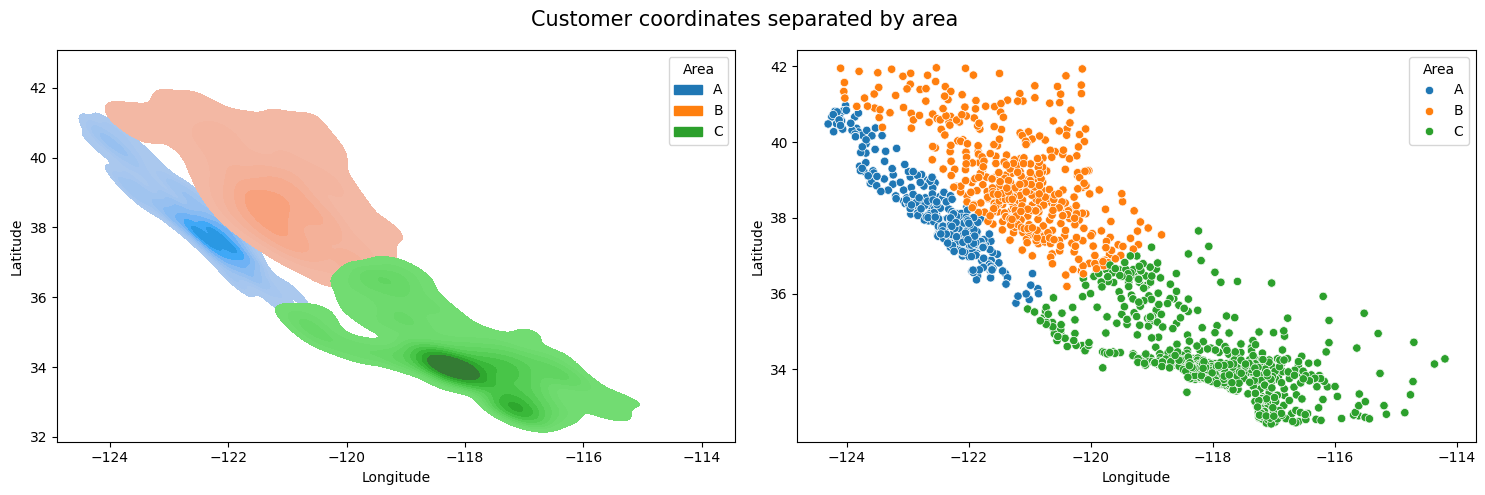

In [6]:
# utilizando condições junto com a função da reta encontrada manualmente
# m: coeficiente angular
# b: intercepto

m_red = (39 - 34) / (-117 - (-123))   
b_red = 34 - m_red * (-123)            
m_green = (36.17 - 42.5) / (-120.5 - (-125))
b_green = 42.5 - m_green * (-125)

areas = []
order_areas = ['A', 'B', 'C']

for _, row in df.iterrows():
    y_red = m_red * row['Longitude'] + b_red
    y_green = m_green * row['Longitude'] + b_green

    if row['Latitude'] <= y_red:
        areas.append('C')
    elif row['Latitude'] <= y_green:
        areas.append('A')
    else:
        areas.append('B')
        
df['Area'] = areas

fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
sns.kdeplot(data=df, x='Longitude', y='Latitude', hue='Area', hue_order=order_areas, fill=True, linewidth=0, ax=axs[0])
sns.scatterplot(data=df, x='Longitude', y='Latitude', hue='Area', hue_order=order_areas, ax=axs[1])
fig.suptitle('Customer coordinates separated by area', size=15)
plt.tight_layout()
plt.show()

---
### Análise qualitativa

-> **Há diferença do status por área?**

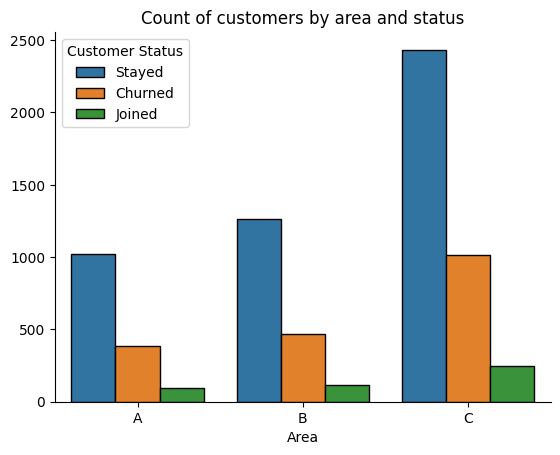

Area A


Customer Status
Stayed     68.042610
Churned    25.699068
Joined      6.258322
Name: proportion, dtype: float64


Area B


Customer Status
Stayed     68.472373
Churned    25.406284
Joined      6.121343
Name: proportion, dtype: float64


Area C


Customer Status
Stayed     65.872801
Churned    27.442490
Joined      6.684709
Name: proportion, dtype: float64

In [10]:
fig, axs = plt.subplots()

sns.countplot(data=df, x='Area', hue='Customer Status', order=order_areas, edgecolor='black', ax=axs)
axs.set_title('Count of customers by area and status')
axs.set_ylabel(None)
remove_spines(axs)
plt.show()

for area in order_areas:
    print(f'Area {area}')
    display(df[df['Area']==area]['Customer Status'].value_counts(normalize=True)*100)
    print()

A proporção do status é praticamente igual para todas as áreas.

-> **A categoria do churn é igual para todas as áreas?**

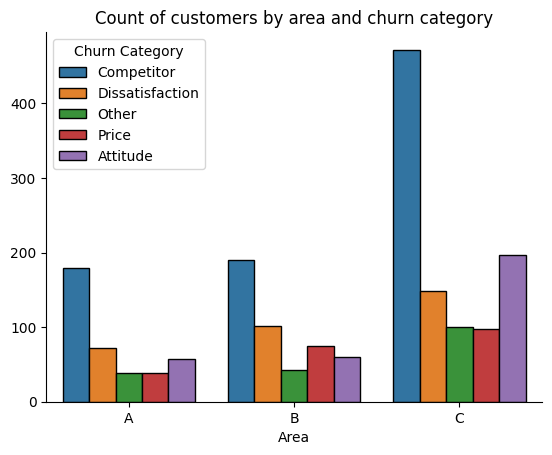

Area A


Churn Category
Competitor         46.373057
Dissatisfaction    18.652850
Attitude           14.766839
Price              10.103627
Other              10.103627
Name: proportion, dtype: float64


Area B


Churn Category
Competitor         40.511727
Dissatisfaction    21.535181
Price              15.991471
Attitude           12.793177
Other               9.168443
Name: proportion, dtype: float64


Area C


Churn Category
Competitor         46.548323
Attitude           19.428008
Dissatisfaction    14.595661
Other               9.861933
Price               9.566075
Name: proportion, dtype: float64

In [ ]:
fig, axs = plt.subplots()

sns.countplot(
    data=df[df['Customer Status']=='Churned'], 
    x='Area', 
    hue='Churn Category', 
    order=order_areas, edgecolor='black',
    ax=axs
)
axs.set_title('Count of customers by area and churn category')
axs.set_ylabel(None)
remove_spines(axs)
plt.show()

for area in order_areas:
    print(f'Area {area}')
    display(
        df[(df['Area']==area) & (df['Customer Status']=='Churned')]['Churn Category']
           .value_counts(normalize=True)*100
        )
    print()

Apesar das categorias de churn manterem um formato de proporção parecido, há diferenças pontuais entre as áreas. Por exemplo, o fato atitude (provavelmente a qualidade do atendimento prestado) na área C é mais proeminente que nas restantes.

Além disso, o fator preço também difere nas três áreas, sendo um fator mais relevante na área B, ao contrário da área C.

**A diferença na proporção das categorias de churn é estatisticamente relevante?**

In [38]:
from scipy.stats import chi2_contingency

df_churn_category = df[df['Customer Status']=='Churned']
df_churn_category_contingency = pd.crosstab(index=df_churn_category['Area'], columns=df_churn_category['Churn Category'])

pvalue = chi2_contingency(df_churn_category_contingency).pvalue

print(f'P-value: {pvalue}')
print(f'P-value is less than 0.5: {pvalue < .5}')

P-value: 3.2014694777188054e-05
P-value is less than 0.5: True


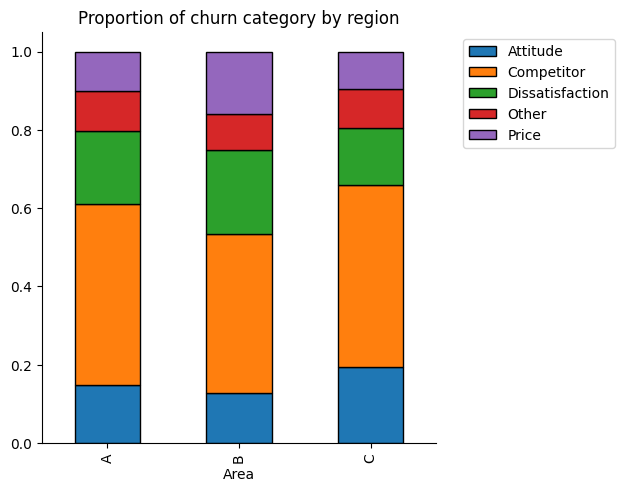

In [49]:
df_stacked_categories = df_churn_category_contingency.div(df_churn_category_contingency.sum(axis=1), axis=0)

fig, axs = plt.subplots()
df_stacked_categories.plot(
    kind='bar', 
    stacked=True, 
    edgecolor='black', 
    ax=axs
)
remove_spines(axs)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.title('Proportion of churn category by region')
plt.show()

*Resgatar novos motivos utilizados na primeira versão*